In [10]:
# ===============================================================
# 🔰 Step 1 — Import Libraries
# ===============================================================
import numpy as np
import pandas as pd
import os, time
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


In [11]:
# ===============================================================
# 🔰 Step 2 — Device Setup & Data Preparation
# ===============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ Dataset path (change if needed)
DATA_DIR = "/kaggle/input/saad-3/Microscopic Image Dataset of Plant-Parasitic Nematodes"

# ✅ Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ✅ Load dataset
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)

# ✅ Split 40:60 (Train:Test)
test_ratio = 0.6
test_size = int(test_ratio * len(dataset))
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")

# ✅ Split 10% of Train as Validation
val_ratio = 0.1
val_size = int(val_ratio * len(train_dataset))
train_size_final = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size_final, val_size])
print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

# ✅ Dataloader setup
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Using device: cuda
Train: 407, Test: 609
Train: 367, Validation: 40, Test: 609


In [12]:
# ===============================================================
# 🔰 Step 3 — Model: MobileNetV2
# ===============================================================
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

# ✅ Load pretrained weights
weights = MobileNet_V2_Weights.DEFAULT
model = mobilenet_v2(weights=weights)

# ✅ Replace final classifier layer
num_classes = len(dataset.classes)
model.classifier[1] = nn.Linear(model.last_channel, num_classes)

# ✅ Move to device
model = model.to(device)

# ✅ Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [13]:
# ===============================================================
# 🔰 Step 4 — Train & Evaluate Functions
# ===============================================================
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total


def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    return running_loss / total, correct / total, np.array(all_preds), np.array(all_labels), np.array(all_probs)


In [14]:
# ===============================================================
# 🔰 Step 5 — Training Loop
# ===============================================================
num_epochs = 50
train_losses, val_losses = [], []
train_accs, val_accs = [], []
best_val_acc = 0.0

start_time = time.time()
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _, _ = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_mobilenetv2_model.pth")

end_time = time.time()
print(f"\n✅ Total training time: {end_time - start_time:.2f} sec")



Epoch 1/50


Train Loss: 2.3417, Acc: 0.1335 | Val Loss: 2.3025, Acc: 0.2500

Epoch 2/50


Train Loss: 2.0755, Acc: 0.4959 | Val Loss: 2.1537, Acc: 0.3000

Epoch 3/50


Train Loss: 1.8457, Acc: 0.6376 | Val Loss: 2.0184, Acc: 0.4000

Epoch 4/50


Train Loss: 1.6223, Acc: 0.7030 | Val Loss: 1.8796, Acc: 0.4000

Epoch 5/50


Train Loss: 1.4036, Acc: 0.7820 | Val Loss: 1.7452, Acc: 0.5000

Epoch 6/50


Train Loss: 1.2087, Acc: 0.8093 | Val Loss: 1.6384, Acc: 0.5500

Epoch 7/50


Train Loss: 1.0187, Acc: 0.8583 | Val Loss: 1.5507, Acc: 0.5750

Epoch 8/50


Train Loss: 0.8757, Acc: 0.8719 | Val Loss: 1.4632, Acc: 0.5500

Epoch 9/50


Train Loss: 0.7068, Acc: 0.8910 | Val Loss: 1.4004, Acc: 0.5500

Epoch 10/50


Train Loss: 0.5903, Acc: 0.9292 | Val Loss: 1.3351, Acc: 0.5750

Epoch 11/50


Train Loss: 0.4587, Acc: 0.9455 | Val Loss: 1.3013, Acc: 0.5500

Epoch 12/50


Train Loss: 0.3656, Acc: 0.9646 | Val Loss: 1.2200, Acc: 0.5500

Epoch 13/50


Train Loss: 0.3095, Acc: 0.9782 | Val Loss: 1.2092, Acc: 0.5500

Epoch 14/50


Train Loss: 0.2311, Acc: 0.9782 | Val Loss: 1.1799, Acc: 0.6000

Epoch 15/50


Train Loss: 0.1782, Acc: 0.9864 | Val Loss: 1.1752, Acc: 0.6000

Epoch 16/50


Train Loss: 0.1449, Acc: 0.9864 | Val Loss: 1.1394, Acc: 0.6000

Epoch 17/50


Train Loss: 0.1180, Acc: 0.9918 | Val Loss: 1.1296, Acc: 0.6000

Epoch 18/50


Train Loss: 0.0995, Acc: 0.9918 | Val Loss: 1.1228, Acc: 0.6000

Epoch 19/50


Train Loss: 0.0891, Acc: 0.9946 | Val Loss: 1.1494, Acc: 0.5750

Epoch 20/50


Train Loss: 0.0715, Acc: 0.9973 | Val Loss: 1.1663, Acc: 0.6000

Epoch 21/50


Train Loss: 0.0698, Acc: 0.9918 | Val Loss: 1.1667, Acc: 0.6000

Epoch 22/50


Train Loss: 0.0609, Acc: 0.9973 | Val Loss: 1.2174, Acc: 0.5500

Epoch 23/50


Train Loss: 0.0572, Acc: 0.9973 | Val Loss: 1.2038, Acc: 0.5500

Epoch 24/50


Train Loss: 0.0457, Acc: 0.9973 | Val Loss: 1.1842, Acc: 0.6000

Epoch 25/50


Train Loss: 0.0542, Acc: 0.9918 | Val Loss: 1.2053, Acc: 0.5750

Epoch 26/50


Train Loss: 0.0343, Acc: 1.0000 | Val Loss: 1.1895, Acc: 0.5750

Epoch 27/50


Train Loss: 0.0381, Acc: 1.0000 | Val Loss: 1.2126, Acc: 0.5750

Epoch 28/50


Train Loss: 0.0366, Acc: 1.0000 | Val Loss: 1.2516, Acc: 0.5500

Epoch 29/50


Train Loss: 0.0293, Acc: 0.9973 | Val Loss: 1.2329, Acc: 0.5750

Epoch 30/50


Train Loss: 0.0261, Acc: 1.0000 | Val Loss: 1.2170, Acc: 0.5750

Epoch 31/50


Train Loss: 0.0277, Acc: 1.0000 | Val Loss: 1.1570, Acc: 0.6000

Epoch 32/50


Train Loss: 0.0230, Acc: 1.0000 | Val Loss: 1.1678, Acc: 0.6000

Epoch 33/50


Train Loss: 0.0223, Acc: 1.0000 | Val Loss: 1.2383, Acc: 0.5750

Epoch 34/50


Train Loss: 0.0193, Acc: 1.0000 | Val Loss: 1.2427, Acc: 0.6000

Epoch 35/50


Train Loss: 0.0155, Acc: 1.0000 | Val Loss: 1.2551, Acc: 0.6000

Epoch 36/50


Train Loss: 0.0198, Acc: 1.0000 | Val Loss: 1.2485, Acc: 0.5750

Epoch 37/50


Train Loss: 0.0152, Acc: 1.0000 | Val Loss: 1.2651, Acc: 0.5750

Epoch 38/50


Train Loss: 0.0189, Acc: 1.0000 | Val Loss: 1.2497, Acc: 0.6250

Epoch 39/50


Train Loss: 0.0163, Acc: 1.0000 | Val Loss: 1.2495, Acc: 0.6250

Epoch 40/50


Train Loss: 0.0119, Acc: 1.0000 | Val Loss: 1.2477, Acc: 0.6250

Epoch 41/50


Train Loss: 0.0126, Acc: 1.0000 | Val Loss: 1.2704, Acc: 0.6000

Epoch 42/50


Train Loss: 0.0144, Acc: 1.0000 | Val Loss: 1.2257, Acc: 0.6250

Epoch 43/50


Train Loss: 0.0214, Acc: 0.9973 | Val Loss: 1.2346, Acc: 0.6250

Epoch 44/50


Train Loss: 0.0112, Acc: 1.0000 | Val Loss: 1.2876, Acc: 0.6000

Epoch 45/50


Train Loss: 0.0106, Acc: 1.0000 | Val Loss: 1.2957, Acc: 0.6000

Epoch 46/50


Train Loss: 0.0113, Acc: 1.0000 | Val Loss: 1.2994, Acc: 0.6250

Epoch 47/50


Train Loss: 0.0086, Acc: 1.0000 | Val Loss: 1.2875, Acc: 0.6250

Epoch 48/50


Train Loss: 0.0095, Acc: 1.0000 | Val Loss: 1.2965, Acc: 0.6250

Epoch 49/50


Train Loss: 0.0090, Acc: 1.0000 | Val Loss: 1.4213, Acc: 0.6000

Epoch 50/50


Train Loss: 0.0068, Acc: 1.0000 | Val Loss: 1.3717, Acc: 0.6000

✅ Total training time: 416.17 sec


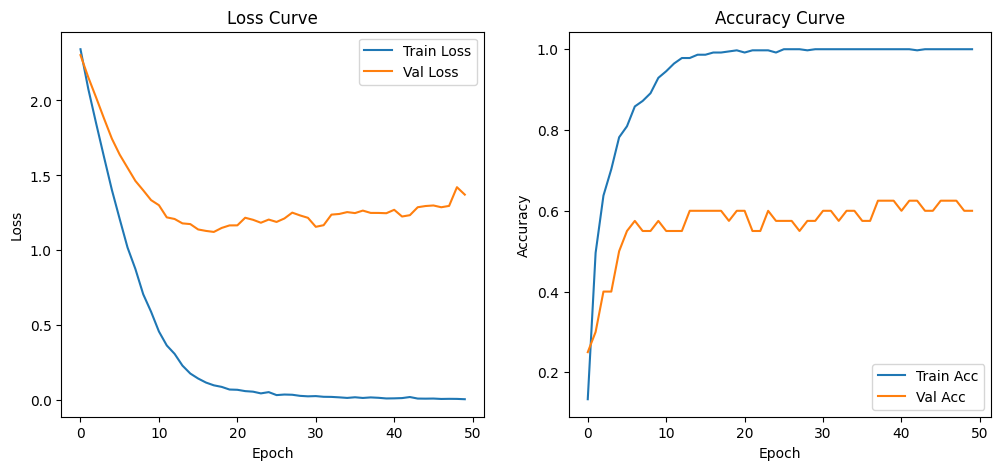

In [15]:
# ===============================================================
# 🔰 Step 6 — Plot Loss & Accuracy Curves
# ===============================================================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [16]:
# ===============================================================
# 🔰 Step 7 — Test Evaluation
# ===============================================================
model.load_state_dict(torch.load("best_mobilenetv2_model.pth"))
test_start = time.time()
test_loss, test_acc, all_preds, all_labels, all_probs = evaluate(model, test_loader, criterion)
test_end = time.time()

print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"✅ Test time: {test_end - test_start:.2f} sec")



✅ Test Accuracy: 65.02%
✅ Test time: 10.92 sec



Classification Report:
                       precision    recall  f1-score   support

      Genus Criconema     0.0000    0.0000    0.0000         3
  Genus Criconemoides     0.7606    0.8571    0.8060        63
Genus Helicotylenchus     0.7500    0.8514    0.7975        74
Genus Hemicycliophora     0.0000    0.0000    0.0000         4
 Genus Hirschmaniella     0.5976    0.6622    0.6282        74
    Genus Hoplolaimus     0.6607    0.8222    0.7327        90
    Genus Meloidogyne     0.5982    0.5000    0.5447       134
   Genus Pratylenchus     0.4559    0.4697    0.4627        66
     Genus Radopholus     1.0000    0.2609    0.4138        23
    Genus Trichodorus     0.7097    0.9565    0.8148        23
      Genus Xiphinema     0.6977    0.5455    0.6122        55

             accuracy                         0.6502       609
            macro avg     0.5664    0.5387    0.5284       609
         weighted avg     0.6487    0.6502    0.6366       609



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


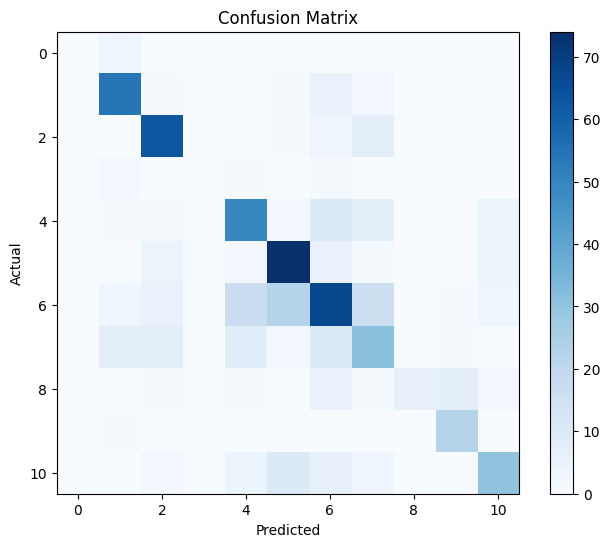


Per-class Accuracy:
Genus Criconema: 0.00%
Genus Criconemoides: 85.71%
Genus Helicotylenchus: 85.14%
Genus Hemicycliophora: 0.00%
Genus Hirschmaniella: 66.22%
Genus Hoplolaimus: 82.22%
Genus Meloidogyne: 50.00%
Genus Pratylenchus: 46.97%
Genus Radopholus: 26.09%
Genus Trichodorus: 95.65%
Genus Xiphinema: 54.55%


In [17]:
# ===============================================================
# 🔰 Step 8 — Classification Report & Confusion Matrix
# ===============================================================
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

unique_labels = sorted(list(set(all_labels)))
target_names = [dataset.classes[i] for i in unique_labels]

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, labels=unique_labels, target_names=target_names, digits=4))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.show()

per_class_acc = cm.diagonal() / cm.sum(axis=1)
print("\nPer-class Accuracy:")
for i, label_idx in enumerate(unique_labels):
    cls_name = dataset.classes[label_idx]
    print(f"{cls_name}: {per_class_acc[i]*100:.2f}%")


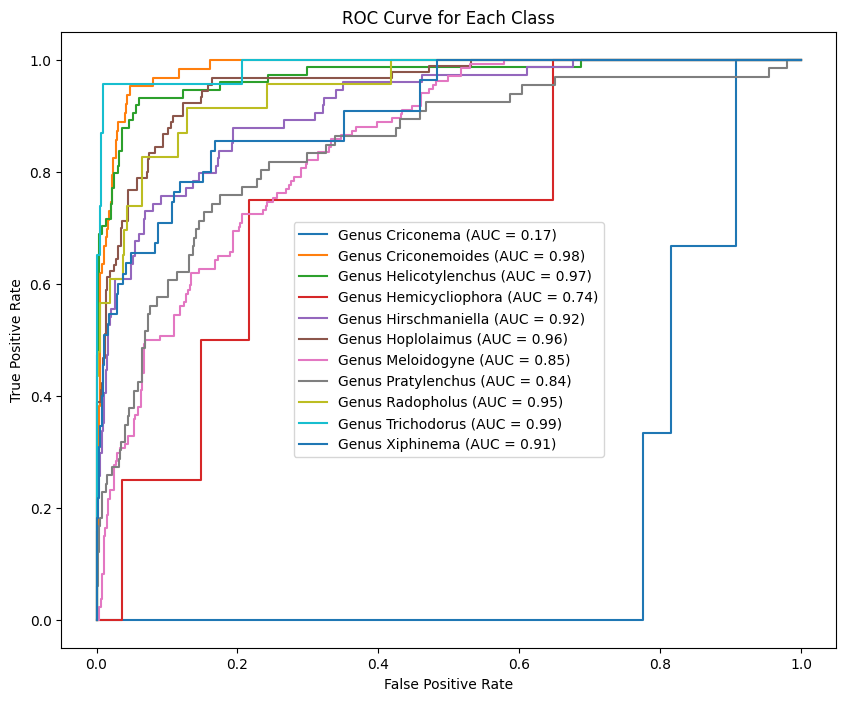

In [18]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Convert to numpy if needed
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

plt.figure(figsize=(10, 8))
for i, cls in enumerate(dataset.classes):
    binary_labels = (all_labels == i).astype(int)
    fpr, tpr, _ = roc_curve(binary_labels, all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC = {roc_auc:.2f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Class")
plt.legend()
plt.show()
